<a href="https://colab.research.google.com/github/rudysemola/CL-experiments/blob/main/CLaaS-DEMO-v1-Exp/CLaaS_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLaaS v1

In [ ]:
!pip install git+https://github.com/ContinualAI/avalanche.git

# SplitMNIST 

In [77]:
import avalanche
from avalanche.benchmarks.classic import SplitMNIST
from avalanche.models import SimpleMLP
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import accuracy_metrics, \
    timing_metrics, cpu_usage_metrics, disk_usage_metrics, gpu_usage_metrics, ram_usage_metrics
from avalanche.training.strategies import Replay
from avalanche.training.strategies import Naive, Cumulative

import torch
from torch.optim import SGD
from torch.nn import CrossEntropyLoss

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# scenario
scenario = SplitMNIST(n_experiences=5)

# MODEL CREATION
model = SimpleMLP(num_classes=scenario.n_classes)

#logger
monitoring_logger = InteractiveLogger()

#gpu
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")
#Eval plugin
eval_plugin = EvaluationPlugin(
            accuracy_metrics(experience=True, stream=True),
            timing_metrics(epoch=True),
            cpu_usage_metrics(epoch=True),
            disk_usage_metrics(epoch=True),
            ram_usage_metrics(epoch=True),
            gpu_usage_metrics(gpu_id=device.index,epoch=True),
            loggers=[monitoring_logger]
        ) 

In [66]:
# Utility function
def build_results(results:list,list_metric:list, key_res:str, do_avg=True):
  for i in range(len(results)):
    list_metric.append(results[i][key_res])
    avg = sum(list_metric) / len(list_metric)
  if do_avg:
    return avg
  else:
    return list_metric

# Init: Naive, Cum, CL
avg_time = {}
stream_acc = {} 
acc_exp = {}

## Naive

In [24]:
# CREATE THE STRATEGY INSTANCE (NAIVE)
naive_strategy = Naive(
    model, SGD(model.parameters(), lr=0.001, momentum=0.9),
    CrossEntropyLoss(), train_mb_size=500, train_epochs=1, eval_mb_size=100,
    evaluator=eval_plugin)

# TRAINING LOOP
print('Starting experiment...')
results_naive = []
res_naive = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res_naive.append(naive_strategy.train(experience, num_workers=4))
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # eval also returns a dictionary which contains all the metric values
    results_naive.append(naive_strategy.eval(scenario.test_stream, num_workers=4))

Starting experiment...
Start of experience:  0
Current Classes:  [0, 8]
-- >> Start of training phase << --
-- Starting training on experience 0 (Task 0) from train stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 24/24 [00:03<00:00,  6.45it/s]
Epoch 0 ended.
	CPUUsage_Epoch/train_phase/train_stream/Task000 = 36.9884
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 55532.3242
	MaxGPU0Usage_Epoch/train_phase/train_stream/Task000 = 0
	MaxRAMUsage_Epoch/train_phase/train_stream/Task000 = 3258.9453
	Time_Epoch/train_phase/train_stream/Task000 = 3.6500
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 20/20 [00:00<00:00, 23.20it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9729
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 23.62it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.0000
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 21/21 [00:00<00:00, 24.11it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.0000
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 22/22 [00:00<00:00, 24.55it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.0000
-- Starting eval on experience 4 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 23.56it/s]
> Eval on experience 4 (Task 0) from test st

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 25/25 [00:03<00:00,  6.66it/s]
Epoch 0 ended.
	CPUUsage_Epoch/train_phase/train_stream/Task000 = 37.1982
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 55532.3242
	MaxGPU0Usage_Epoch/train_phase/train_stream/Task000 = 0
	MaxRAMUsage_Epoch/train_phase/train_stream/Task000 = 3259.7266
	Time_Epoch/train_phase/train_stream/Task000 = 3.6857
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 20/20 [00:00<00:00, 23.88it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0000
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 23.02it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.9807
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 21/21 [00:00<00:00, 22.93it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.0000
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 22/22 [00:00<00:00, 24.41it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.0000
-- Starting eval on experience 4 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 24.02it/s]
> Eval on experience 4 (Task 0) from test st

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 25/25 [00:03<00:00,  6.70it/s]
Epoch 0 ended.
	CPUUsage_Epoch/train_phase/train_stream/Task000 = 36.5984
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 55532.3242
	MaxGPU0Usage_Epoch/train_phase/train_stream/Task000 = 0
	MaxRAMUsage_Epoch/train_phase/train_stream/Task000 = 3259.7656
	Time_Epoch/train_phase/train_stream/Task000 = 3.6626
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 20/20 [00:00<00:00, 23.63it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0870
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 23.59it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.1839
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 21/21 [00:00<00:00, 24.96it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.9662
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 22/22 [00:00<00:00, 24.53it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.0000
-- Starting eval on experience 4 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 23.66it/s]
> Eval on experience 4 (Task 0) from test st

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 26/26 [00:03<00:00,  6.65it/s]
Epoch 0 ended.
	CPUUsage_Epoch/train_phase/train_stream/Task000 = 36.5330
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 55532.3242
	MaxGPU0Usage_Epoch/train_phase/train_stream/Task000 = 0
	MaxRAMUsage_Epoch/train_phase/train_stream/Task000 = 3259.9180
	Time_Epoch/train_phase/train_stream/Task000 = 3.8073
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 20/20 [00:00<00:00, 24.24it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.1904
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 23.21it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.1077
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 21/21 [00:00<00:00, 24.74it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.0000
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 22/22 [00:00<00:00, 24.45it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.9869
-- Starting eval on experience 4 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 23.38it/s]
> Eval on experience 4 (Task 0) from test st

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 23/23 [00:03<00:00,  6.40it/s]
Epoch 0 ended.
	CPUUsage_Epoch/train_phase/train_stream/Task000 = 37.5801
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 55532.3242
	MaxGPU0Usage_Epoch/train_phase/train_stream/Task000 = 0
	MaxRAMUsage_Epoch/train_phase/train_stream/Task000 = 3260.2734
	Time_Epoch/train_phase/train_stream/Task000 = 3.5136
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 20/20 [00:01<00:00, 19.05it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.1095
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 20/20 [00:01<00:00, 15.47it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.0061
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 21/21 [00:01<00:00, 20.08it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.0090
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 22/22 [00:00<00:00, 24.09it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.8531
-- Starting eval on experience 4 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 23.97it/s]
> Eval on experience 4 (Task 0) from test st

In [27]:
results_naive[-1]

{'CPUUsage_Epoch/train_phase/train_stream/Task000': 37.58006107880272,
 'DiskUsage_Epoch/train_phase/train_stream/Task000': 55532.32421875,
 'MaxGPU0Usage_Epoch/train_phase/train_stream/Task000': 0,
 'MaxRAMUsage_Epoch/train_phase/train_stream/Task000': 3260.2734375,
 'Time_Epoch/train_phase/train_stream/Task000': 3.5135589859999072,
 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.10951893551688843,
 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001': 0.006097560975609756,
 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002': 0.008955223880597015,
 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003': 0.8530783582089553,
 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004': 0.8872141372141372,
 'Top1_Acc_Stream/eval_phase/test_stream/Task000': 0.378}

In [68]:
# time
timing_list = []
avg_time['Naive'] = build_results(results_naive,timing_list, 'Time_Epoch/train_phase/train_stream/Task000')

# SA
stream_acc['Naive'] = results_naive[-1]['Top1_Acc_Stream/eval_phase/test_stream/Task000']

# Acc list for exp
acc_exp['Naive'] = build_results(results_naive,list_metric=[], key_res='Top1_Acc_Stream/eval_phase/test_stream/Task000', do_avg=False)


avg_time, stream_acc, acc_exp

({'Naive': 3.663811848399928},
 {'Naive': 0.378},
 {'Naive': [0.1901, 0.193, 0.2474, 0.27, 0.378]})

## Cumulative

In [51]:
# CREATE THE STRATEGY INSTANCE (NAIVE)
cum_strategy= Cumulative(
    model, SGD(model.parameters(), lr=0.001, momentum=0.9),
    CrossEntropyLoss(), train_mb_size=500, train_epochs=1, eval_mb_size=100,
    evaluator=eval_plugin)

# TRAINING LOOP
print('Starting experiment...')
results_cum = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cum_strategy.train(experience, num_workers=4)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # eval also returns a dictionary which contains all the metric values
    results_cum.append(cum_strategy.eval(scenario.test_stream, num_workers=4))

Starting experiment...
Start of experience:  0
Current Classes:  [0, 8]
-- >> Start of training phase << --
-- Starting training on experience 0 (Task 0) from train stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 24/24 [00:03<00:00,  6.48it/s]
Epoch 0 ended.
	CPUUsage_Epoch/train_phase/train_stream/Task000 = 36.9142
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 55532.3242
	MaxGPU0Usage_Epoch/train_phase/train_stream/Task000 = 0
	MaxRAMUsage_Epoch/train_phase/train_stream/Task000 = 3260.3438
	Time_Epoch/train_phase/train_stream/Task000 = 3.6347
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 20/20 [00:00<00:00, 23.48it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9585
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 22.74it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.1128
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 21/21 [00:00<00:00, 23.49it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.0234
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 22/22 [00:00<00:00, 23.91it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.6674
-- Starting eval on experience 4 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 23.80it/s]
> Eval on experience 4 (Task 0) from test st

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 48/48 [00:08<00:00,  5.68it/s]
Epoch 0 ended.
	CPUUsage_Epoch/train_phase/train_stream/Task000 = 33.8185
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 55532.3242
	MaxGPU0Usage_Epoch/train_phase/train_stream/Task000 = 0
	MaxRAMUsage_Epoch/train_phase/train_stream/Task000 = 3262.1523
	Time_Epoch/train_phase/train_stream/Task000 = 8.3737
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 20/20 [00:00<00:00, 22.69it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9079
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 23.40it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.9243
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 21/21 [00:00<00:00, 21.15it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.0040
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 22/22 [00:01<00:00, 17.88it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.0350
-- Starting eval on experience 4 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 23.49it/s]
> Eval on experience 4 (Task 0) from test st

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 72/72 [00:14<00:00,  5.12it/s]
Epoch 0 ended.
	CPUUsage_Epoch/train_phase/train_stream/Task000 = 30.6467
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 55532.3242
	MaxGPU0Usage_Epoch/train_phase/train_stream/Task000 = 0
	MaxRAMUsage_Epoch/train_phase/train_stream/Task000 = 3264.8008
	Time_Epoch/train_phase/train_stream/Task000 = 13.9988
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 20/20 [00:00<00:00, 22.31it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9212
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 22.64it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.9217
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 21/21 [00:00<00:00, 23.62it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.9373
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 22/22 [00:00<00:00, 22.23it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.0317
-- Starting eval on experience 4 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 20.87it/s]
> Eval on experience 4 (Task 0) from test st

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 98/98 [00:17<00:00,  5.71it/s]
Epoch 0 ended.
	CPUUsage_Epoch/train_phase/train_stream/Task000 = 32.9007
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 55532.3242
	MaxGPU0Usage_Epoch/train_phase/train_stream/Task000 = 0
	MaxRAMUsage_Epoch/train_phase/train_stream/Task000 = 3267.1094
	Time_Epoch/train_phase/train_stream/Task000 = 17.0534
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 20/20 [00:00<00:00, 22.36it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9156
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 23.54it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.9238
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 21/21 [00:00<00:00, 23.38it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.9010
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 22/22 [00:00<00:00, 24.06it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.8783
-- Starting eval on experience 4 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 22.78it/s]
> Eval on experience 4 (Task 0) from test st

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 120/120 [00:18<00:00,  6.44it/s]
Epoch 0 ended.
	CPUUsage_Epoch/train_phase/train_stream/Task000 = 24.8285
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 55532.3242
	MaxGPU0Usage_Epoch/train_phase/train_stream/Task000 = 0
	MaxRAMUsage_Epoch/train_phase/train_stream/Task000 = 3269.7305
	Time_Epoch/train_phase/train_stream/Task000 = 18.4887
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 20/20 [00:00<00:00, 23.37it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8961
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 23.24it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.9096
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 21/21 [00:00<00:00, 22.66it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.9070
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 22/22 [00:00<00:00, 23.57it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.9030
-- Starting eval on experience 4 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 23.12it/s]
> Eval on experience 4 (Task 0) from test st

In [53]:
results_cum

[{'CPUUsage_Epoch/train_phase/train_stream/Task000': 36.91423869890618,
  'DiskUsage_Epoch/train_phase/train_stream/Task000': 55532.32421875,
  'MaxGPU0Usage_Epoch/train_phase/train_stream/Task000': 0,
  'MaxRAMUsage_Epoch/train_phase/train_stream/Task000': 3260.34375,
  'Time_Epoch/train_phase/train_stream/Task000': 3.6346678240001893,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.9585465711361311,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001': 0.11280487804878049,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002': 0.023383084577114428,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003': 0.6674440298507462,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004': 0.28794178794178793,
  'Top1_Acc_Stream/eval_phase/test_stream/Task000': 0.4127},
 {'CPUUsage_Epoch/train_phase/train_stream/Task000': 33.81848192597608,
  'DiskUsage_Epoch/train_phase/train_stream/Task000': 55532.32421875,
  'MaxGPU0Usage_Epoch/train_phase/train_stream/Task000': 0,
  'MaxRAMUsage

In [71]:
# time
timing_list = []
avg_time['Cum'] = build_results(results_cum,timing_list, 'Time_Epoch/train_phase/train_stream/Task000')

# SA
stream_acc['Cum'] = results_cum[-1]['Top1_Acc_Stream/eval_phase/test_stream/Task000']

# Acc list for exp
acc_exp['Cum'] = build_results(results_cum,list_metric=[], key_res='Top1_Acc_Stream/eval_phase/test_stream/Task000', do_avg=False)


avg_time, stream_acc, acc_exp

({'Cum': 12.309847889400043, 'Naive': 3.663811848399928},
 {'Cum': 0.8731, 'Naive': 0.378},
 {'Cum': [0.4127, 0.3676, 0.5566, 0.7301, 0.8731],
  'Naive': [0.1901, 0.193, 0.2474, 0.27, 0.378]})

## CL Strategy (Random Replay)

In [56]:
# CREATE THE STRATEGY INSTANCE (NAIVE)
cl_strategy_replay = Replay(
            model, SGD(model.parameters(), lr=0.001, momentum=0.9),
            CrossEntropyLoss(), train_mb_size=500, train_epochs=1, eval_mb_size=100,
            evaluator=eval_plugin)

# TRAINING LOOP
print('Starting experiment...')
results_cl = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy_replay.train(experience, num_workers=4)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # eval also returns a dictionary which contains all the metric values
    results_cl.append(cl_strategy_replay.eval(scenario.test_stream, num_workers=4))

Starting experiment...
Start of experience:  0
Current Classes:  [0, 8]
-- >> Start of training phase << --
-- Starting training on experience 0 (Task 0) from train stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 24/24 [00:03<00:00,  6.35it/s]
Epoch 0 ended.
	CPUUsage_Epoch/train_phase/train_stream/Task000 = 37.0102
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 55532.3242
	MaxGPU0Usage_Epoch/train_phase/train_stream/Task000 = 0
	MaxRAMUsage_Epoch/train_phase/train_stream/Task000 = 3266.2773
	Time_Epoch/train_phase/train_stream/Task000 = 3.7015
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 20/20 [00:00<00:00, 23.58it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9841
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 23.50it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.6413
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 21/21 [00:00<00:00, 24.33it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.8085
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 22/22 [00:00<00:00, 24.16it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.6768
-- Starting eval on experience 4 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 23.76it/s]
> Eval on experience 4 (Task 0) from test st

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  2%|▏         | 1/49 [00:00<00:44,  1.08it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  4%|▍         | 2/49 [00:01<00:30,  1.55it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  6%|▌         | 3/49 [00:01<00:27,  1.65it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  8%|▊         | 4/49 [00:02<00:24,  1.83it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 10%|█         | 5/49 [00:02<00:21,  2.04it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 12%|█▏        | 6/49 [00:03<00:23,  1.80it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 14%|█▍        | 7/49 [00:03<00:22,  1.85it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 16%|█▋        | 8/49 [00:04<00:20,  1.98it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 18%|█▊        | 9/49 [00:04<00:18,  2.13it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 20%|██        | 10/49 [00:05<00:17,  2.20it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 24%|██▍       | 12/49 [00:06<00:16,  2.27it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 27%|██▋       | 13/49 [00:06<00:15,  2.27it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 29%|██▊       | 14/49 [00:06<00:15,  2.29it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 31%|███       | 15/49 [00:07<00:16,  2.02it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 33%|███▎      | 16/49 [00:08<00:15,  2.09it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 35%|███▍      | 17/49 [00:08<00:14,  2.16it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 37%|███▋      | 18/49 [00:08<00:14,  2.19it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 39%|███▉      | 19/49 [00:09<00:12,  2.31it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 41%|████      | 20/49 [00:09<00:12,  2.32it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 45%|████▍     | 22/49 [00:11<00:16,  1.67it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 47%|████▋     | 23/49 [00:11<00:15,  1.66it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 49%|████▉     | 24/49 [00:12<00:15,  1.63it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 51%|█████     | 25/49 [00:12<00:14,  1.70it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 53%|█████▎    | 26/49 [00:13<00:12,  1.89it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 55%|█████▌    | 27/49 [00:13<00:11,  2.00it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 59%|█████▉    | 29/49 [00:14<00:09,  2.17it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 61%|██████    | 30/49 [00:15<00:08,  2.19it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 63%|██████▎   | 31/49 [00:15<00:07,  2.25it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 65%|██████▌   | 32/49 [00:15<00:07,  2.25it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 67%|██████▋   | 33/49 [00:16<00:08,  1.85it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 69%|██████▉   | 34/49 [00:17<00:07,  1.95it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 71%|███████▏  | 35/49 [00:17<00:07,  1.94it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 73%|███████▎  | 36/49 [00:18<00:06,  2.01it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 76%|███████▌  | 37/49 [00:18<00:05,  2.11it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 78%|███████▊  | 38/49 [00:18<00:05,  2.13it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 80%|███████▉  | 39/49 [00:19<00:05,  1.97it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 82%|████████▏ | 40/49 [00:19<00:04,  2.06it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 84%|████████▎ | 41/49 [00:20<00:03,  2.13it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 86%|████████▌ | 42/49 [00:20<00:03,  2.10it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 88%|████████▊ | 43/49 [00:21<00:02,  2.28it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 92%|█████████▏| 45/49 [00:22<00:01,  2.40it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 94%|█████████▍| 46/49 [00:22<00:01,  2.48it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 96%|█████████▌| 47/49 [00:22<00:00,  2.57it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 49/49 [00:23<00:00,  2.06it/s]
Epoch 0 ended.
	CPUUsage_Epoch/train_phase/train_stream/Task000 = 48.5491
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 55532.3242
	MaxGPU0Usage_Epoch/train_phase/train_stream/Task000 = 0
	MaxRAMUsage_Epoch/train_phase/train_stream/Task000 = 3267.6797
	Time_Epoch/train_phase/train_stream/Task000 = 23.5223
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 20/20 [00:00<00:00, 21.53it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9504
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 22.17it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.9568
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 21/21 [00:01<00:00, 19.32it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.7776
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 22/22 [00:00<00:00, 22.88it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.6842
-- Starting eval on experience 4 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 21.43it/s]
> Eval on experience 4 (Task 0) from test st

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  2%|▏         | 1/49 [00:01<00:47,  1.00it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  4%|▍         | 2/49 [00:01<00:31,  1.51it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  6%|▌         | 3/49 [00:01<00:25,  1.79it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  8%|▊         | 4/49 [00:02<00:22,  2.01it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 10%|█         | 5/49 [00:02<00:21,  2.09it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 12%|█▏        | 6/49 [00:03<00:19,  2.16it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 16%|█▋        | 8/49 [00:04<00:18,  2.25it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 18%|█▊        | 9/49 [00:04<00:18,  2.22it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 20%|██        | 10/49 [00:04<00:17,  2.29it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 22%|██▏       | 11/49 [00:05<00:16,  2.36it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 24%|██▍       | 12/49 [00:05<00:15,  2.33it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 29%|██▊       | 14/49 [00:06<00:15,  2.32it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 31%|███       | 15/49 [00:07<00:14,  2.33it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 33%|███▎      | 16/49 [00:07<00:14,  2.32it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 35%|███▍      | 17/49 [00:07<00:13,  2.31it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 37%|███▋      | 18/49 [00:08<00:13,  2.36it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 39%|███▉      | 19/49 [00:08<00:13,  2.30it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 43%|████▎     | 21/49 [00:09<00:12,  2.32it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 45%|████▍     | 22/49 [00:10<00:11,  2.30it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 47%|████▋     | 23/49 [00:10<00:11,  2.32it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 49%|████▉     | 24/49 [00:10<00:10,  2.33it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 51%|█████     | 25/49 [00:11<00:10,  2.38it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 53%|█████▎    | 26/49 [00:11<00:09,  2.33it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 57%|█████▋    | 28/49 [00:12<00:08,  2.36it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 59%|█████▉    | 29/49 [00:13<00:08,  2.29it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 61%|██████    | 30/49 [00:13<00:08,  2.28it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 63%|██████▎   | 31/49 [00:13<00:07,  2.28it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 65%|██████▌   | 32/49 [00:14<00:07,  2.28it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 67%|██████▋   | 33/49 [00:14<00:06,  2.34it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 69%|██████▉   | 34/49 [00:15<00:06,  2.30it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 73%|███████▎  | 36/49 [00:16<00:05,  2.29it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 76%|███████▌  | 37/49 [00:16<00:05,  2.29it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 78%|███████▊  | 38/49 [00:16<00:04,  2.28it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 80%|███████▉  | 39/49 [00:17<00:04,  2.28it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 82%|████████▏ | 40/49 [00:17<00:03,  2.37it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 84%|████████▎ | 41/49 [00:18<00:03,  2.32it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 88%|████████▊ | 43/49 [00:19<00:02,  2.41it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 90%|████████▉ | 44/49 [00:19<00:02,  2.47it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 92%|█████████▏| 45/49 [00:19<00:01,  2.58it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 96%|█████████▌| 47/49 [00:20<00:00,  2.57it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 98%|█████████▊| 48/49 [00:20<00:00,  2.60it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 49/49 [00:21<00:00,  2.28it/s]
Epoch 0 ended.
	CPUUsage_Epoch/train_phase/train_stream/Task000 = 52.2101
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 55532.3242
	MaxGPU0Usage_Epoch/train_phase/train_stream/Task000 = 0
	MaxRAMUsage_Epoch/train_phase/train_stream/Task000 = 3267.8125
	Time_Epoch/train_phase/train_stream/Task000 = 21.2646
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 20/20 [00:00<00:00, 21.27it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9273
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 21.69it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.9172
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 21/21 [00:00<00:00, 21.92it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.9642
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 22/22 [00:00<00:00, 22.03it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.4398
-- Starting eval on experience 4 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 21.36it/s]
> Eval on experience 4 (Task 0) from test st

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  2%|▏         | 1/51 [00:00<00:47,  1.05it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  4%|▍         | 2/51 [00:01<00:32,  1.53it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  6%|▌         | 3/51 [00:01<00:26,  1.83it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  8%|▊         | 4/51 [00:02<00:23,  2.01it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 10%|▉         | 5/51 [00:02<00:22,  2.06it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 12%|█▏        | 6/51 [00:03<00:21,  2.11it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 16%|█▌        | 8/51 [00:04<00:19,  2.20it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 18%|█▊        | 9/51 [00:04<00:18,  2.22it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 20%|█▉        | 10/51 [00:04<00:18,  2.21it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 22%|██▏       | 11/51 [00:05<00:18,  2.22it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 24%|██▎       | 12/51 [00:05<00:17,  2.23it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 25%|██▌       | 13/51 [00:06<00:16,  2.25it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 27%|██▋       | 14/51 [00:06<00:16,  2.26it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 29%|██▉       | 15/51 [00:07<00:16,  2.25it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 33%|███▎      | 17/51 [00:08<00:14,  2.27it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 35%|███▌      | 18/51 [00:08<00:14,  2.27it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 37%|███▋      | 19/51 [00:08<00:13,  2.29it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 39%|███▉      | 20/51 [00:09<00:13,  2.29it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 41%|████      | 21/51 [00:09<00:12,  2.34it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 43%|████▎     | 22/51 [00:10<00:12,  2.31it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 47%|████▋     | 24/51 [00:11<00:11,  2.30it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 49%|████▉     | 25/51 [00:11<00:11,  2.25it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 51%|█████     | 26/51 [00:11<00:10,  2.27it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 53%|█████▎    | 27/51 [00:12<00:10,  2.29it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 55%|█████▍    | 28/51 [00:12<00:10,  2.28it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 57%|█████▋    | 29/51 [00:13<00:09,  2.34it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 59%|█████▉    | 30/51 [00:13<00:09,  2.30it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 63%|██████▎   | 32/51 [00:14<00:08,  2.30it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 65%|██████▍   | 33/51 [00:14<00:07,  2.28it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 67%|██████▋   | 34/51 [00:15<00:07,  2.27it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 69%|██████▊   | 35/51 [00:15<00:06,  2.29it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 71%|███████   | 36/51 [00:16<00:06,  2.27it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 73%|███████▎  | 37/51 [00:16<00:06,  2.30it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 75%|███████▍  | 38/51 [00:17<00:05,  2.29it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 78%|███████▊  | 40/51 [00:18<00:04,  2.27it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 80%|████████  | 41/51 [00:18<00:04,  2.28it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 82%|████████▏ | 42/51 [00:18<00:03,  2.26it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 84%|████████▍ | 43/51 [00:19<00:03,  2.33it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 86%|████████▋ | 44/51 [00:19<00:02,  2.43it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 90%|█████████ | 46/51 [00:20<00:02,  2.49it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 92%|█████████▏| 47/51 [00:20<00:01,  2.50it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 94%|█████████▍| 48/51 [00:21<00:01,  2.61it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 98%|█████████▊| 50/51 [00:22<00:00,  2.58it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 51/51 [00:22<00:00,  2.26it/s]
Epoch 0 ended.
	CPUUsage_Epoch/train_phase/train_stream/Task000 = 52.6826
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 55532.3242
	MaxGPU0Usage_Epoch/train_phase/train_stream/Task000 = 0
	MaxRAMUsage_Epoch/train_phase/train_stream/Task000 = 3267.8125
	Time_Epoch/train_phase/train_stream/Task000 = 22.4174
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 20/20 [00:00<00:00, 21.96it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8941
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 21.20it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.9273
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 21/21 [00:00<00:00, 21.84it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.7498
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 22/22 [00:01<00:00, 21.46it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.9664
-- Starting eval on experience 4 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 21.25it/s]
> Eval on experience 4 (Task 0) from test st

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  2%|▏         | 1/46 [00:01<00:45,  1.00s/it]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  4%|▍         | 2/46 [00:01<00:29,  1.47it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  7%|▋         | 3/46 [00:01<00:24,  1.77it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  9%|▊         | 4/46 [00:02<00:21,  1.91it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 11%|█         | 5/46 [00:02<00:20,  2.03it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 13%|█▎        | 6/46 [00:03<00:19,  2.08it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 15%|█▌        | 7/46 [00:03<00:18,  2.12it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 20%|█▉        | 9/46 [00:04<00:16,  2.19it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 22%|██▏       | 10/46 [00:05<00:16,  2.19it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 24%|██▍       | 11/46 [00:05<00:15,  2.21it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 26%|██▌       | 12/46 [00:05<00:15,  2.24it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 28%|██▊       | 13/46 [00:06<00:14,  2.23it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 30%|███       | 14/46 [00:06<00:13,  2.29it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 33%|███▎      | 15/46 [00:07<00:13,  2.26it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 35%|███▍      | 16/46 [00:07<00:13,  2.21it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 39%|███▉      | 18/46 [00:08<00:12,  2.19it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 41%|████▏     | 19/46 [00:09<00:12,  2.15it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 43%|████▎     | 20/46 [00:09<00:12,  2.16it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 46%|████▌     | 21/46 [00:10<00:11,  2.20it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 48%|████▊     | 22/46 [00:10<00:10,  2.24it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 50%|█████     | 23/46 [00:10<00:10,  2.25it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 52%|█████▏    | 24/46 [00:11<00:09,  2.31it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 54%|█████▍    | 25/46 [00:11<00:09,  2.29it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 57%|█████▋    | 26/46 [00:12<00:08,  2.27it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 61%|██████    | 28/46 [00:13<00:07,  2.26it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 63%|██████▎   | 29/46 [00:13<00:07,  2.27it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 65%|██████▌   | 30/46 [00:13<00:07,  2.27it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 67%|██████▋   | 31/46 [00:14<00:06,  2.27it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 70%|██████▉   | 32/46 [00:14<00:06,  2.27it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 72%|███████▏  | 33/46 [00:15<00:05,  2.30it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 74%|███████▍  | 34/46 [00:15<00:05,  2.26it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 78%|███████▊  | 36/46 [00:16<00:04,  2.30it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 80%|████████  | 37/46 [00:17<00:03,  2.26it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 83%|████████▎ | 38/46 [00:17<00:03,  2.30it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 85%|████████▍ | 39/46 [00:17<00:02,  2.36it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 87%|████████▋ | 40/46 [00:18<00:02,  2.42it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 91%|█████████▏| 42/46 [00:19<00:01,  2.48it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 93%|█████████▎| 43/46 [00:19<00:01,  2.46it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 96%|█████████▌| 44/46 [00:19<00:00,  2.53it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 46/46 [00:20<00:00,  2.22it/s]
Epoch 0 ended.
	CPUUsage_Epoch/train_phase/train_stream/Task000 = 51.8578
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 55532.3242
	MaxGPU0Usage_Epoch/train_phase/train_stream/Task000 = 0
	MaxRAMUsage_Epoch/train_phase/train_stream/Task000 = 3268.5703
	Time_Epoch/train_phase/train_stream/Task000 = 20.5831
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 20/20 [00:00<00:00, 20.29it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7160
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 20.93it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.7266
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 21/21 [00:00<00:00, 21.46it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.8423
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 22/22 [00:01<00:00, 21.73it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.8745
-- Starting eval on experience 4 (Task 0) from test stream --
100%|██████████| 20/20 [00:00<00:00, 21.00it/s]
> Eval on experience 4 (Task 0) from test st

In [57]:
results_cl

[{'CPUUsage_Epoch/train_phase/train_stream/Task000': 37.01019992374201,
  'DiskUsage_Epoch/train_phase/train_stream/Task000': 55532.32421875,
  'MaxGPU0Usage_Epoch/train_phase/train_stream/Task000': 0,
  'MaxRAMUsage_Epoch/train_phase/train_stream/Task000': 3266.27734375,
  'Time_Epoch/train_phase/train_stream/Task000': 3.7014823610002168,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.9841351074718526,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001': 0.641260162601626,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002': 0.8084577114427861,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003': 0.6767723880597015,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004': 0.21205821205821207,
  'Top1_Acc_Stream/eval_phase/test_stream/Task000': 0.6669},
 {'CPUUsage_Epoch/train_phase/train_stream/Task000': 48.54912687415447,
  'DiskUsage_Epoch/train_phase/train_stream/Task000': 55532.32421875,
  'MaxGPU0Usage_Epoch/train_phase/train_stream/Task000': 0,
  'MaxRAMUsage_

In [72]:
# time
timing_list = []
avg_time['CL_Replay'] = build_results(results_cl,timing_list, 'Time_Epoch/train_phase/train_stream/Task000')

# SA
stream_acc['CL_Replay'] = results_cl[-1]['Top1_Acc_Stream/eval_phase/test_stream/Task000']

# Acc list for exp
acc_exp['CL_Replay'] = build_results(results_cl,list_metric=[], key_res='Top1_Acc_Stream/eval_phase/test_stream/Task000', do_avg=False)


avg_time, stream_acc, acc_exp

({'CL_Replay': 18.297765459400033,
  'Cum': 12.309847889400043,
  'Naive': 3.663811848399928},
 {'CL_Replay': 0.8204, 'Cum': 0.8731, 'Naive': 0.378},
 {'CL_Replay': [0.6669, 0.6986, 0.6722, 0.7413, 0.8204],
  'Cum': [0.4127, 0.3676, 0.5566, 0.7301, 0.8731],
  'Naive': [0.1901, 0.193, 0.2474, 0.27, 0.378]})

## Results and Plot

- **Performance** (Stream Accuracy)
- **Efficiency** ( timing_metrics, cpu_usage_metrics, disk_usage_metrics, gpu_usage_metrics, ram_usage_metrics) -> CL/N% CL/Cum%

PLOT 
- Acc | Eff metrics | in experiences

In [73]:
avg_time

{'CL_Replay': 18.297765459400033,
 'Cum': 12.309847889400043,
 'Naive': 3.663811848399928}

In [74]:
stream_acc

{'CL_Replay': 0.8204, 'Cum': 0.8731, 'Naive': 0.378}

In [75]:
acc_exp

{'CL_Replay': [0.6669, 0.6986, 0.6722, 0.7413, 0.8204],
 'Cum': [0.4127, 0.3676, 0.5566, 0.7301, 0.8731],
 'Naive': [0.1901, 0.193, 0.2474, 0.27, 0.378]}

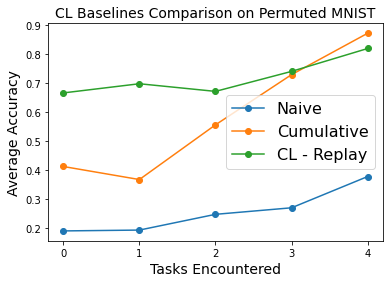

In [82]:
plt.plot(range(scenario.n_experiences), acc_exp['Naive'], '-o', label="Naive")
plt.plot(range(scenario.n_experiences), acc_exp['Cum'], '-o', label="Cumulative")
plt.plot(range(scenario.n_experiences), acc_exp['CL_Replay'], '-o', label="CL - Replay")
plt.xlabel('Tasks Encountered', fontsize=14)
plt.ylabel('Average Accuracy', fontsize=14)
plt.title('CL Baselines Comparison on Permuted MNIST', fontsize=14);
plt.xticks(range(scenario.n_experiences))
plt.legend(prop={'size': 16});

# CORe50

## Naive

## Cumulative

## CL strategy (Random Replay)

## Results and Plot

- **Performance** (Stream Accuracy)
- **Efficiency** ( timing_metrics, cpu_usage_metrics, disk_usage_metrics, gpu_usage_metrics, ram_usage_metrics)

What Else?